In [137]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from flame_net.lib_uti import count_learnable_params
from flame_net.libSiva import CSolverSiva
#from flame_net.uti_plot import *
import os

from flame_net.libSiva import libSiva
from flame_net.libData import libData


%matplotlib inline
import pickle

#np.random.seed(seed=1653)


In [138]:
device = torch.device('cuda')
bRNN=False
T_in=1
data_channel = 1 # model.data_channel


In [139]:
#models[-2] #['model_name_detail'] = 'ONet_nu07_nStep20_branchfc_P50_feature5_best'


In [196]:
models=[
        {'model_name_detail':'Fourier_m128w30nu02_share_skip'              ,'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
        #{'model_name_detail':'Fourier_m32w20nu07_share_skip'               ,'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
        {'model_name_detail':'Fourier_m64w20nu07_share_skip_o20_Revision__best'               ,'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
        #{'model_name_detail':'Conv_nu02_16_32_64_64_128_64_32_16_o20_ep800','nu':0.02,'nStep':1,'Tout':20,'Tin':1},
        #{'model_name_detail':'old_Conv/Conv_nu02_16_32_64_64_128_128_128_128_o10_best','nu':0.02,'nStep':1,'Tout':20,'Tin':1},
        #{'model_name_detail':'old_Conv/Conv_nu07_o20'                         ,'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
        #{'model_name_detail':'old_Conv/Conv_nu07_best'                        ,'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
        #{'model_name_detail':'old_Conv/Conv_nu02_16_32_64_64_128_64_64_64_o1_best'  ,'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
        {'model_name_detail':'Conv_nu07_inception_less_o20_Revision__ep800'   ,'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
        {'model_name_detail':'Conv_nu07_inception_less_o1_Revision__best'    ,'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
        {'model_name_detail':'Conv_nu02_inception_less_o20_best'   ,'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
        {'model_name_detail':'Conv_nu02_inception_less_o1_best'    ,'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
        {'model_name_detail':'Fourier_m64w20nu07_share_skip_o1_Revision__best'            ,'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
        #{'model_name_detail':'Fourier_m32w20nu07_share_skip_o1'            ,'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
        {'model_name_detail':'Fourier_m128w30nu02_share_skip_o1'           ,'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
        {'model_name_detail':'ONet_nu07_branchfc_P50_feature5'             ,'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
        {'model_name_detail':'ONet_nu02_nStep20_branchfc_P100_feature5'    ,'nu':0.02,'nStep':20,'Tout':1,'Tin':1},
        {'model_name_detail':'ONet_nu07_nStep20_branchfc_P50_feature5_best','nu':0.07,'nStep':20,'Tout':1,'Tin':1},
        {'model_name_detail':'ONet_nu02_branchfc_P50_feature5_o1_best'     ,'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
       # {'model_name_detail':'ONet_nu07_branchfc_P50_feature5_o2'     ,'nu':0.07,'nStep':1,'Tout':2,'Tin':1},
        {'model_name_detail':'ONet_nu07_Tin20_branchfc_P50_o1_best'     ,'nu':0.07,'nStep':1,'Tout':1,'Tin':20},
    
]


In [197]:
def load_pkl( m ):
    str_filename = m['model_name_detail'] 
    if str_filename.find('_ep') >=0: 
        str_filename  = str_filename[ : str_filename.find('_ep') ]
    if str_filename.find('_best')>=0:
        str_filename  = str_filename[ : str_filename.find('_best') ]
    open_file=open('./checkpoints/'+str_filename+ 'trainlog.pkl','rb')
    output_dict= pickle.load(open_file)
    open_file.close()
    #return output_dict    
    train_residual = np.array ( [ os for os  in output_dict['list_output_info'] ] )
    return train_residual 
    
def plot_training_resid( m, list_iy=[4,5], ys='log',ix=0):
    train_residual = load_pkl( m)
    line_style = ['r-', 'g-.','b--','k.']
    for idx, y in enumerate(list_iy):
        plt.plot( train_residual[:,ix], train_residual[:,y], line_style[idx])
        #plt.plot( train_residual[:,ix], train_residual[:,y],'b-')
    plt.yscale(ys)
    
    return [ train_residual[:, y ][-1] for  y in list_iy ]

def print_train_info( list_iy=[4,5,1], models=models ):
    for idx, m in enumerate( models):
        train_residual = load_pkl( m)
        #----------------
        if 'ONet' in m['model_name_detail']:
            method='ONet'
        elif  'Fourier' in m['model_name_detail']:
            method='Fourier'
        elif  'Conv' in m['model_name_detail']:
            method='Conv'
        #----------------
        print(idx, method, m['nu'], m['nStep'] ,m['Tout'],m['Tin'],  [ train_residual[:, y ][-1] for  y in list_iy ] ) 

In [198]:
print_train_info()

0 Fourier 0.02 1 20 1 [0.016466318044229034, 0.01707798275719495, 20.272472145967185]
1 Fourier 0.07 1 20 1 [0.008277327517668406, 0.008065396795670192, 21.48821416683495]
2 Conv 0.07 1 20 1 [0.006058310717344284, 0.006578162126243114, 34.11160490475595]
3 Conv 0.07 1 1 1 [0.0009288158230408877, 0.0009368016390141123, 20.233749312348664]
4 Conv 0.02 1 20 1 [0.018620267366353558, 0.018703662248554166, 123.76100430905353]
5 Conv 0.02 1 1 1 [0.0018805819968273792, 0.0019064436031230173, 29.5219868440181]
6 Fourier 0.07 1 1 1 [0.0008806833523308825, 0.0008716446842124802, 9.665496765635908]
7 Fourier 0.02 1 1 1 [0.0017710082065481693, 0.0017722336046240056, 39.149440536275506]
8 ONet 0.07 1 1 1 [0.19707326115374585, 0.19807340629608278, 3.506169356405735]
9 ONet 0.02 20 1 1 [0.10341995125651982, 0.10917788580872193, 3.8124769972637296]
10 ONet 0.07 20 1 1 [0.07415478407818338, 0.10891904582148013, 3.4415725599974394]
11 ONet 0.02 1 1 1 [0.05879501543592379, 0.059736156267127506, 3.92205555

[0.006058310717344284, 0.006578162126243114]

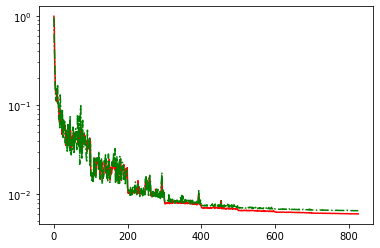

In [199]:
plot_training_resid (  models[2], [4,5],  ys='log' )

[0.10341995125651982, 0.10917788580872193]

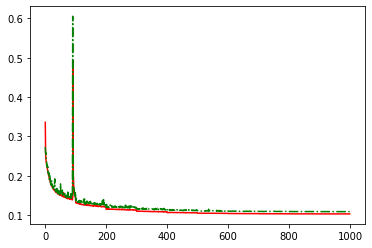

In [200]:
plot_training_resid(models[9],ys='linear')

In [201]:

def load_model( model_name_detail):
    LocalFull_filename_Saved_Model =  './checkpoints/' + model_name_detail
    model = torch.load( LocalFull_filename_Saved_Model, map_location='cuda')
    print(model_name_detail, ' loaded in: count_learnable_params =' + str( count_learnable_params(model) ))
    return model

def get_model(name, nu,nStep,Tout,Tin, models=models, bLoadModel=True):
    if 'fno' in name.casefold():
        name_internal = 'fourier'
    elif 'cnn' in name.casefold() or 'cas' in name.casefold():
        name_internal = 'conv'
    elif 'onet' in name.casefold():
        name_internal = 'onet'
        
    for m in models:
        if name_internal in m['model_name_detail'].casefold() and  m['nu']==nu and   m['nStep']==nStep and   m['Tout']==Tout and m['Tin']==Tin: 
            if 'model' not in m  and bLoadModel==True:
                m['model'] = load_model( m['model_name_detail'] )
            return m
    raise ValueError('did not find model')

def update_model_pred(m):
    #if 'model' not in m:
    m['model'] = load_model( m['model_name_detail'] )
    
    list_pred = get_model_pred(m)
    # list_pred.shape == (4, 512, 2000)
    m['list_pred'] = np.moveaxis(list_pred,1,-1)
    print('list_pred.shape=', m['list_pred'].shape)

    #----
    nu = m['nu']
    sys = get_sys(nu)    
    #----

    #m['list_d_an'] = sys['list_d_an']
    #m['list_NormalizedTotalLen_an'] = sys['list_NormalizedTotalLen_an']
    m['sys'] = sys
    m['x'] = sys['x']
    m['list_NormalizedTotalLen_pred'] = libData.dsol_to_whole_length(m['x'], m['list_pred']  )
    return m

def get_model_pred(m):
    nu    = m['nu'] 
    nStep = m['nStep']
    Tin   = m['Tin']
    
    #d0    = get_d0_all_from_nu(nu)
    
    sys = get_sys(nu)
    
    d0=sys['list_d_an'][:,:Tin,:] 
    
    #d0_torch = torch.tensor(d0,dtype=torch.float) #.unsqueeze(-1)
    d0_torch =torch.tensor(d0,dtype=torch.float).permute((0,2,1))
    
    with torch.no_grad():
        model = m['model']
        xx = d0_torch
        xx = xx.to(device)
        
        if Tin == 1: 
            for t in range(2000//nStep):
                im = model(xx) # , torch.tensor([nu]))
                #--------------------
                if torch.any( torch.isnan(im) ) == True :
                    if 'fourier' in m['model_name_detail'].casefold() and m['Tout']==20:
                        print('the solution diverged at step', t, ', you can try change rand_seed of', torch.where(torch.isnan(im))[0] )
                        raise ValueError("Nan")
                        break
                #--------------------
                if t == 0:
                    pred = torch.cat((xx, im), -1)
                else:
                    pred = torch.cat((pred, im), -1)
                xx = torch.cat((xx[..., 1 * data_channel:], im), dim=-1)
                
        else: # Tin>1 
            
            for t in range(2000//nStep -(T_in-1) ):
                im = model(xx) # , torch.tensor([nu]))
                
                if t == 0:
                    pred = torch.cat((xx, im), -1)
                else:
                    pred = torch.cat((pred, im), -1)
                xx = torch.cat((xx[..., 1*data_channel:], im), dim=-1)
            
    return pred.detach().cpu().numpy()


In [202]:
#list__init_str = ['rand_FFT_2_8','rand_FFT_2_8','rand_simple','rand_simple' ]
list__init_str = ['rand_FFT_2_8','rand_simple','rand_FFT_2_8','rand_simple' ]
list__init_str_LongTerm=[3]
#list__init_str_LongTerm=[]
siva = [
  {'nu':0.02, 'SivaEq':CSolverSiva([0.02]), 'N':512 ,'list_randseed':[66,1217,29163,16616] },
  #{'nu':0.02, 'SivaEq':CSolverSiva([0.02]), 'N':512 ,'list_randseed':[5,1216,6,10] },
  {'nu':0.07, 'SivaEq':CSolverSiva([0.07]), 'N':128 ,'list_randseed':[32,61,101,112] }  #[32,81,101,112]
]

N= 512 ,dt_Output= 0.015 ,nu_list = [0.02] ,nu_extention_list = [0.02] ,NumOutPut_dt= [37]
ActiveNoise_Amplitude=0.000000,stepfeq=1,k = 0 
N= 128 ,dt_Output= 0.015 ,nu_list = [0.07] ,nu_extention_list = [0.07, 0.125, 0.4, 0.7] ,NumOutPut_dt= [10 10 10 10]
ActiveNoise_Amplitude=0.000000,stepfeq=1,k = 0 


In [203]:
def get_sys(nu,siva=siva):
    for sys in siva:
        if sys['nu']==nu:
            return sys
    raise ValueError('did not find sys')

def get_d0(i_which,sys,list__init_str=list__init_str):
    np.random.seed(seed= sys['list_randseed'][i_which])
    return sys['SivaEq'].get_init_func_from_txt(list__init_str[i_which])()

def get_d0_from_nu(i_which,nu):
    return  get_d0(i_which, get_sys(nu) )

def get_d0_all_from_nu(nu):
    sys = get_sys(nu)
    d0_all=[]
    for i_which in range( len(sys['list_randseed']) ): 
        d0 = get_d0(i_which, sys )
        d0_all.append(d0)
    return np.array( d0_all )



def update_sys(sys):
    
    d0_all   = get_d0_all_from_nu( sys['nu'] )
    TotalTimeStep=2001
    
    list_d_an=[]

    # --- init starting from either rand_FFT or rand ---
    for d0 in d0_all:
        d_an = sys['SivaEq'].generate_dsol_single(TotalTimeStep, sys['nu'], d0)  # d_an.shape ==numTotalTimeStep,  N
        print('d_an.shape=', d_an.shape)
        list_d_an.append(d_an) 
    
    # --- init starting from a long-term soluton ---
    for i_pick_longterm in list__init_str_LongTerm:
        d0 = list_d_an[i_pick_longterm][-1]
        d_an = sys['SivaEq'].generate_dsol_single(TotalTimeStep, sys['nu'], d0) 
        print('d_an.shape=', d_an.shape)
        list_d_an.append(d_an) 
    
    sys['list_d_an'] = np.array( list_d_an)
    sys['x'] = np.linspace(-1,1,sys['N'],endpoint=False)*np.pi 
    sys['list_NormalizedTotalLen_an'] = libData.dsol_to_whole_length(sys['x'], sys['list_d_an'])
    
    
    return sys





In [204]:

for sys in siva:
    sys = update_sys(sys)

NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 512)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 512)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 512)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 512)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 512)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 128)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 128)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 128)
NumericalSolver_usol: large t.size=( 2001 ); a single-dot is printed for 1000 steps
..d_an.shape= (2001, 128)
NumericalS

In [ ]:
for m_m in models[:] : 
    m_m = update_model_pred(m_m)

Fourier_m128w30nu02_share_skip  loaded in: count_learnable_params =235487
list_pred.shape= (5, 2001, 512)
Fourier_m64w20nu07_share_skip_o20_Revision__best  loaded in: count_learnable_params =54477
list_pred.shape= (5, 2001, 128)
Conv_nu07_inception_less_o20_Revision__ep800  loaded in: count_learnable_params =339733


In [ ]:
#m_m['model'].NN_trunk.nStepPast_Trunk=19
#for m_m in models[-1:] : 
#    m_m = update_model_pred(m_m)

In [ ]:
list_i_t_plot = [0,  50, 100,200,400 ,600,800,1000,1200,1400,1600,1800,2000]
#list_i_t_plot = [1, 20, 50, 80, 100,200,300,500,600,800,1000,1200,1400,1600,1800,2000]

 

In [ ]:

def plot_disp_long(model_name, nu_list, nStep, Tout,Tin, png_filename=None,
                   list_i_t_plot= [0,  50, 100,200,400 ,600,800,1000,1200,1400,1600,1800,2000] ):
    
    #---------------------------------------------------------------------------
    figsize=(12, 5*len(nu_list) )
    fig, axs = plt.subplots(2*len(nu_list),2, sharex=True, sharey=True, figsize= figsize )
    
    #for ax, d_an,pred in zip(axs.reshape(-1), m['sys']['list_d_an'], m['list_pred'] ) :
    for idx, nu in enumerate( nu_list):
        m = get_model(model_name , nu, nStep, Tout, Tin )
        x = m['x']
        for ax, d_an, pred in zip(axs[idx*2:(idx+1)*2,:].reshape(-1), m['sys']['list_d_an'], m['list_pred'] ) :
            for i in list_i_t_plot:
                d = (i)/100
                if i > 0: 
                    h_pred, = ax.plot(  pred[i] + d,   x,'-r')  #, linewidth=1.5 )

                h_ref, = ax.plot(  d_an[i] + d,   x,'--k' , linewidth=1 )


            #---------------------
            #for ax in ax_cols:
            ax.set_yticks( [-np.pi, 0, np.pi] ); 
            ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
            ax.set_ylabel('x', fontsize=14, labelpad=0)

            ax.set_xlim ( [-0.3, 7.2*np.pi] )
            ax.set_xlabel('$\phi(x,t)+t/100$', fontsize=14 )
            ax.set_xticks( [ 0,  2*np.pi,  4*np.pi,  6*np.pi ] );    
            ax.set_xticklabels(['0','2$\pi$', '4$\pi$' ,'6$\pi$' ] , fontsize=14 )
            #---------------------

            
    for ax in axs.flat:
        ax.label_outer()
    #plt.subplots_adjust(left=0.035, right=0.98, top=0.99, bottom=0.08, wspace=0.02)
    #plt.subplots_adjust(left=0.065, right=0.98, top=0.99, bottom=0.13, wspace=0.05)
    #plt.subplots_adjust(left=0.045, right=0.98, top=0.99, bottom=0.1, wspace=0.02,hspace=0.02)

    fig.legend([h_ref,h_pred],['Ref',model_name], bbox_to_anchor=(0.6,0.1/len(nu_list)),ncol=2,fontsize=14  )

    fig.tight_layout()
    #plt.subplots_adjust(left=0.045, right=0.98, top=0.99, bottom=0.13, wspace=0.02, hspace=0.02)
    plt.subplots_adjust(left=0.045, right=0.975, top=0.99,  wspace=0.02, hspace=0.02)

    #fig.text(0.475, 0.005, 'd(x,t)+t/100', ha='center',fontsize=16)
    #fig.text(0.001, 0.52, 'x', va='center', rotation='vertical',fontsize=16 )

    #---------------------

    #fig.text(0.465, 0.001, 't/0.015', ha='center',fontsize=16)
    #fig.text(0.001, 0.52, 'x', va='center', rotation='vertical',fontsize=14 )

    #----
    list_RightText = [ r'$\nu$='+str(nu)   for nu in nu_list[::-1]]
    dy =(1-0.05)/len(nu_list)/2
    #dy =(1-0.05)/len(list_legend)
    for idx in range(2*len(nu_list)):
        ypos = 0.01+(0.5+idx)*dy
        fig.text(0.98, ypos, list_RightText[idx//2],  rotation='vertical',fontsize=14 ,transform=plt.gcf().transFigure) #, weight='bold')
    #---------------------
        
    
    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename, format='eps')
        else:
            plt.savefig(png_filename, dpi=300)
    #return fig,axs

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation, PillowWriter 
import numpy as np

#%matplotlib notebook
def Animate_disp_long(model_name, nu_list, nStep, Tout,Tin, gif_filename=None, dt_nSkip=1, len_t=2000 ):
                   #list_i_t_plot= [0,  50, 100,200,400 ,600,800,1000,1200,1400,1600,1800,2000] ):
    
    #---------------------------------------------------------------------------
    #figsize=(12, 5*len(nu_list) )
    figsize=(12, 12*len(nu_list) )
    fig, axs = plt.subplots(2*len(nu_list),2, sharex=True, sharey=True, figsize= figsize )
    
    #h_pred_all_list=[]
    #h_ref_all_list=[]
    for idx, nu in enumerate( nu_list):
        m = get_model(model_name , nu, nStep, Tout, Tin )
        x = m['x']
        
        h_pred_list=[]
        h_ref_list=[]
        for ax, d_an, pred in zip(axs[idx*2:(idx+1)*2,:].reshape(-1), m['sys']['list_d_an'], m['list_pred'] ) :
            h_pred, = ax.plot([],[],'-r')
            h_ref,  = ax.plot([],[],'--k' , linewidth=1)
            
            h_pred_list.append(h_pred)
            h_ref_list.append(h_ref)
        
            #for i in list_i_t_plot:
                #d = (i)/100
                #if i > 0: 
                #    h_pred, = ax.plot(  pred[i],   x,'-r')  #, linewidth=1.5 )
                #h_ref, = ax.plot(  d_an[i],   x,'--k' , linewidth=1 )
                

            #---------------------
            #for ax in ax_cols:
            ax.set_yticks( [-np.pi, 0, np.pi] ); 
            ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
            ax.set_ylabel('x', fontsize=14, labelpad=0)
            ax.set_ylim ( [-np.pi, np.pi] )

            ax.set_xlim ( [-0.5*np.pi, .8*np.pi] )
            ax.set_xlabel('$\phi(x,t)$', fontsize=14 )
            ax.set_xticks( [ -0.5*np.pi, 0,  .5*np.pi ] );    
            ax.set_xticklabels(['$-\pi/2$', '0','$\pi/2$'] , fontsize=14 )
            #---------------------
        #h_pred_all_list.append(  h_pred_list)
        #h_ref_all_list.append(  h_ref_list)
        
    for ax in axs.flat:
        ax.label_outer()


    fig.tight_layout()
    plt.subplots_adjust(left=0.055, right=0.975, top=0.99, bottom=0.10, wspace=0.02, hspace=0.03)
    fig.legend([h_ref,h_pred],['Ref',model_name], bbox_to_anchor=(0.6,0.07/len(nu_list)),ncol=2,fontsize=14  )

    #----
    list_RightText = [ r'$\nu$='+str(nu)   for nu in nu_list[::-1]]
    dy =(1-0.05)/len(nu_list)/2
    #dy =(1-0.05)/len(list_legend)
    for idx in range(2*len(nu_list)):
        ypos = 0.01+(0.5+idx)*dy
        fig.text(0.98, ypos, list_RightText[idx//2],  rotation='vertical',fontsize=14 ,transform=plt.gcf().transFigure) #, weight='bold')
    #---------------------
        
    def animate(i, dt_nSkip):
        #for nu, h_pred_list, h_ref_list  in zip( nu_list, h_pred_all_list, h_ref_all_list ):
        #    m = get_model(model_name , nu, nStep, Tout, Tin )
        #    x = m['x']
        
        for h_pred,h_ref, d_an, pred in zip( h_pred_list, h_ref_list, m['sys']['list_d_an'], m['list_pred'] ) :        
            if i>0   :# and False:
                h_pred.set_data(pred[i*dt_nSkip], x)
            else:
                h_pred.set_data([],[] )
            h_ref.set_data(d_an[i*dt_nSkip], x)
            
        return h_pred_list, h_ref_list

        
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len_t//dt_nSkip, fargs=(dt_nSkip,))
    if gif_filename is not None:
        ani.save(gif_filename, writer=PillowWriter(fps=10))
    else:
        from IPython.display import HTML
        HTML(ani.to_jshtml())
        ani
        
            


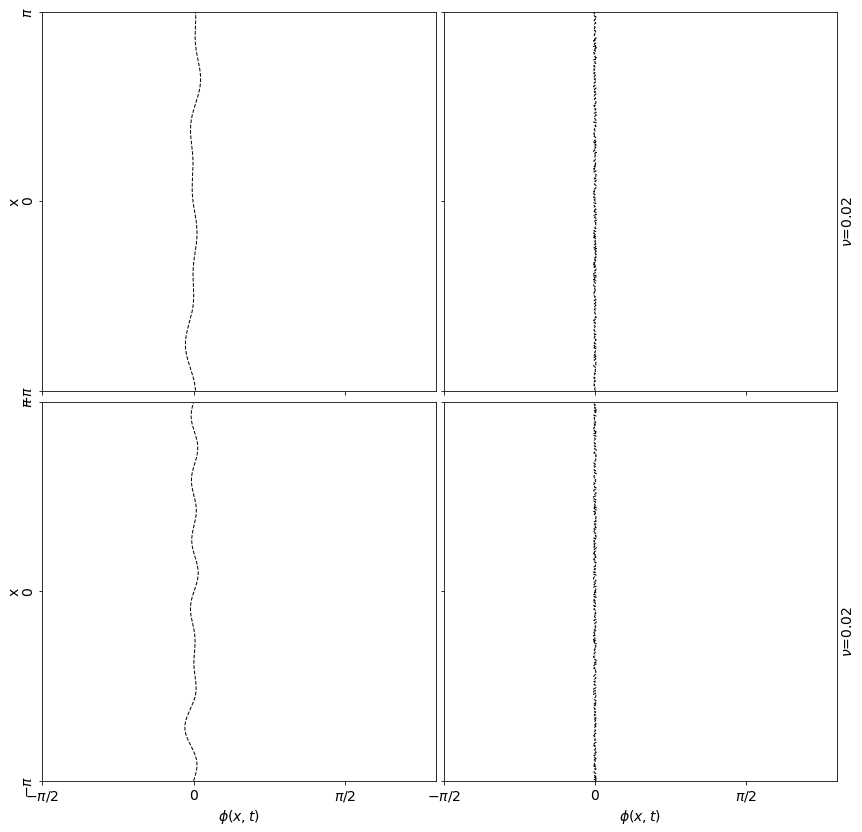

In [29]:

#%matplotlib notebook
model_name, nu, nStep, Tout,Tin,png_filename  ='FNO$_{20}$', 0.02, 1, 20,1 , 'disp_fourier_o20.gif' #None # 'disp_fourier_o20.eps'
#model_name, nu, nStep, Tout,Tin,png_filename  ='FNO$_{20}$', 0.02, 1, 20,1 , 'disp_Ref.gif' # None, 'disp_fourier_o20.eps'
Animate_disp_long(model_name, [0.02], nStep, Tout,Tin,png_filename,1,1000 )


<IPython.core.display.Javascript object>


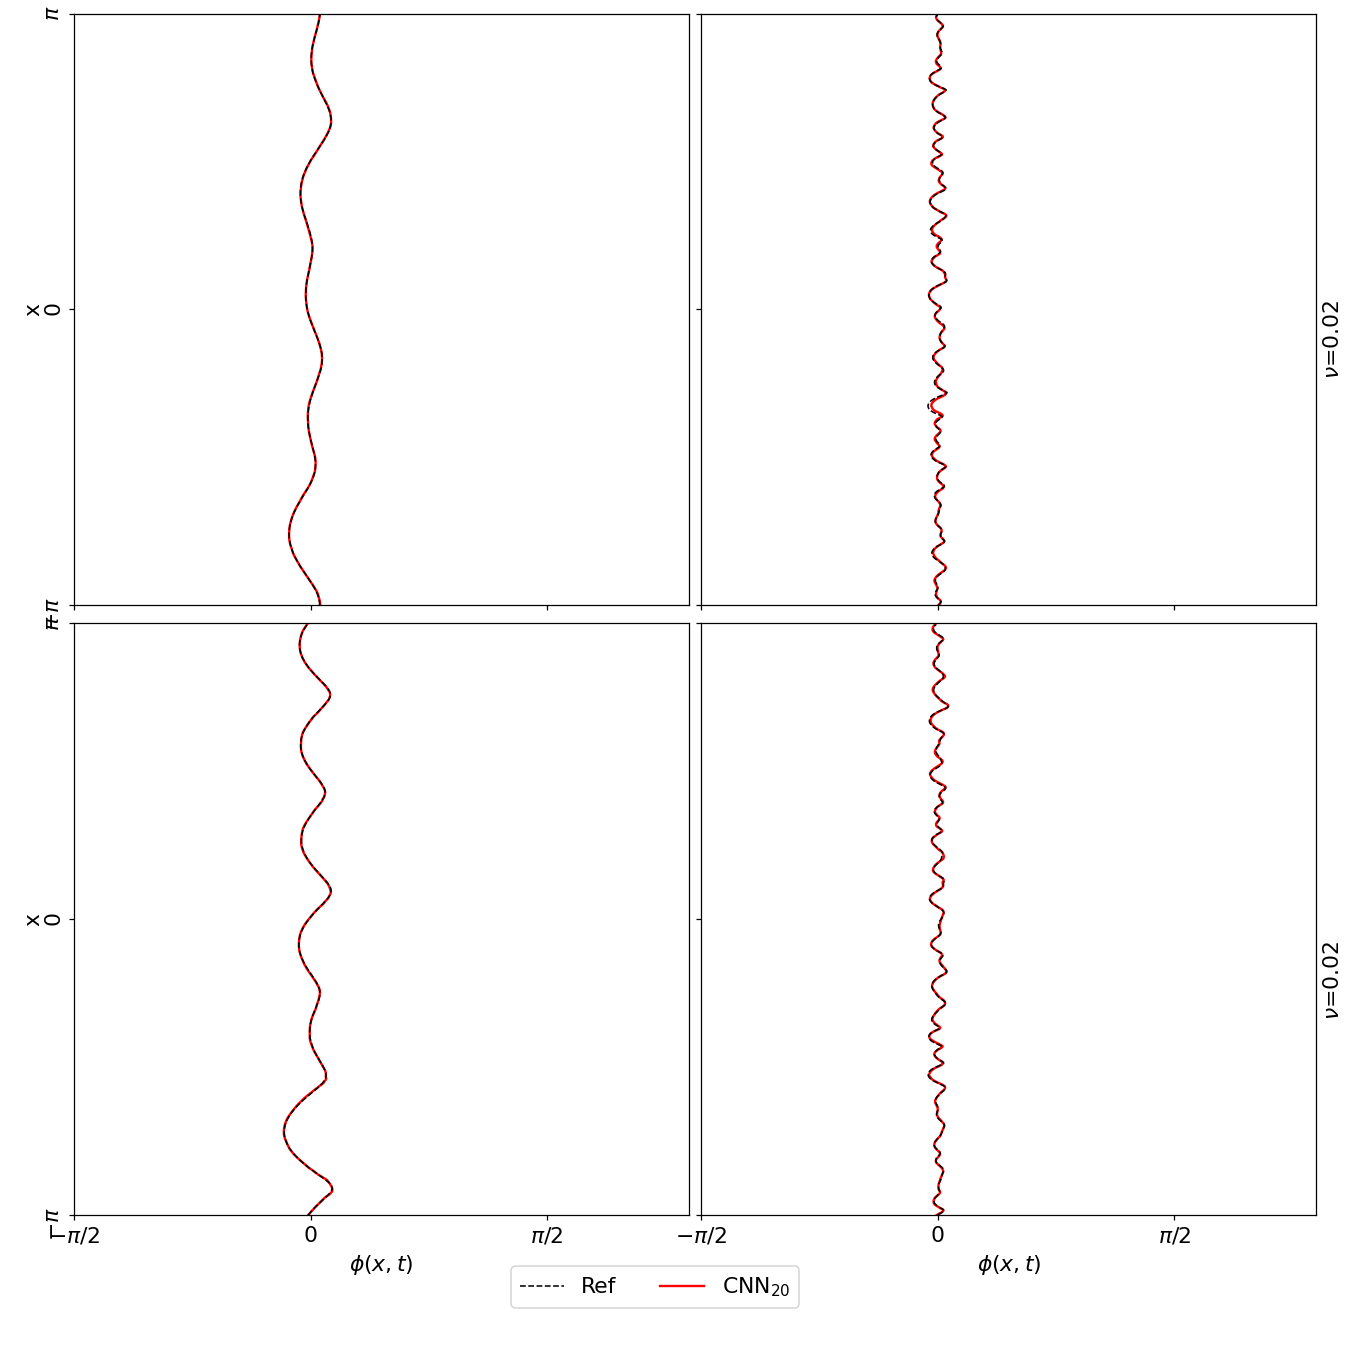

In [53]:
#model_name, nu, nStep, Tout,Tin,png_filename  ='CNN$_{20}$', 0.02, 1, 20,1 , 'disp_conv_o20.gif' #None # 'disp_fourier_o20.eps'
#Animate_disp_long(model_name, [0.02], nStep, Tout,Tin,png_filename,1,1000 )

In [ ]:
model_name, nu, nStep, Tout,Tin,png_filename  ='FNO$_{20}$', 0.02, 1, 20,1, 'disp_fourier_o20_Revision.eps'
plot_disp_long(model_name, [0.02, 0.07], nStep, Tout,Tin,png_filename  )

In [ ]:
model_name, nu, nStep, Tout,Tin,png_filename  ='CNN$_{20}$', 0.02, 1, 20, 1, 'disp_conv_o20_Revision.eps'
plot_disp_long(model_name, [0.02, 0.07], nStep, Tout,Tin,png_filename  )

In [ ]:
#model_name, nu, nStep, Tout,Tin,png_filename  ='ONet$_{1;20}$', 0.07, 1, 1, 20, None 
#plot_disp_long(model_name, [0.07], nStep, Tout, Tin, png_filename  )


In [ ]:
def plot_short_disp(list_models_for_cmp, list__i_pickplot__init_d0=[0,1,4],
                  shortlist_i_t_plot = [0, 8, 20, 40 ,80],
                  png_filename=None):

    
    #figsize=(10,4+2+2+2)
    #figsize=(10,(4+2+2)*len(list_models_for_cmp)   )
    figsize=(10,(4+2)*len(list_models_for_cmp)   )
    
    #---------------------------------------------------------------------------
    fig, axs = plt.subplots( (1+1)*len(list_models_for_cmp) , 3 , sharex=False, sharey=True, figsize= figsize )
    #fig, axs = plt.subplots(1+1+1, 3 , sharex=False, sharey=True, figsize= figsize )

    #pred_allmodes_selectedplot = [ m_['list_pred'][ [1,3,4] ] for m_ in m_all ] 
    
    for i_nu, models_for_cmp in enumerate(list_models_for_cmp):

        nStep_all = [    m_['nStep'] for m_ in models_for_cmp] #[1,1,1,1,20]
        m_all     = [ get_model(**m_) for m_ in models_for_cmp]
        #m_all=[m,mC,m1,m1C,m1o]
        #---------------        
        x = m_all[0]['x']
        pred_all = [ m_['list_pred'] for m_ in m_all ] 
        
        for icol, ax_cols in enumerate( np.transpose(axs[i_nu*2:(i_nu+1)*2,:])) :

            i_pickplot = list__i_pickplot__init_d0[icol]
            #-----------
            d_an     = m_all[0]['sys']['list_d_an'][ i_pickplot ]
            pred_pickplot = [ m_pred[ i_pickplot ] for m_pred in pred_all ]
            #-----------

            #ax.set_yticks( [-np.pi, 0, np.pi] ) ;    ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] , fontsize=14) # rotation='vertical'
            #ax.set_aspect('equal')

            def plot_disp_list(ax,list_m_pick, i_pickplot, pred_pickplot=pred_pickplot,d_an=d_an,list_i_t_plot=shortlist_i_t_plot,nStep_all=nStep_all):
                h_preds = ['' for _ in list_m_pick]
                linesytyle=['-r', '-.g','--c']
                for i in list_i_t_plot:
                    if i_pickplot>=4: 
                        d = (i)/30
                    else:
                        d = (i)/80

                    for idx, m_pick in enumerate(list_m_pick):
                        nStep = nStep_all[m_pick]
                        if i%nStep==0 and i>0: # for those with nStep >1
                            i_actual = i//nStep
                            h_preds[idx], = ax.plot(  pred_pickplot[m_pick][i_actual]+d,   x, linesytyle[idx] ); 

                    h_ref, = ax.plot(  d_an[i] + d,   x,':k' , linewidth=1 )

                return [h_ref, *h_preds]

            h_s0 = plot_disp_list(ax_cols[0], [ 0, 1] ,i_pickplot )
            h_s1 = plot_disp_list(ax_cols[1], [ 2, 3, 4] ,i_pickplot )
            #h_s1 = plot_disp_list(ax_cols[1], [ 2, 3] ,i_pickplot )
            #if len(m_all) ==6: 
            #    h_s2=plot_disp_list(ax_cols[2], [ 4, 5] ,i_pickplot )
            #else:
            #    h_s2=plot_disp_list(ax_cols[2], [ 4   ] ,i_pickplot )

            if icol==2: 
                ax_cols[0].legend(h_s0,['Ref', models_for_cmp[0]['name'] ,models_for_cmp[1]['name']], fontsize=12)
                #ax_cols[1].legend(h_s1,['Ref', models_for_cmp[2]['name'] ,models_for_cmp[3]['name']], fontsize=12)
                ax_cols[1].legend(h_s1,['Ref', models_for_cmp[2]['name'] ,models_for_cmp[3]['name'],models_for_cmp[4]['name']], fontsize=12)
                #if len(m_all)==6:
                #    ax_cols[2].legend(h_s2,['Ref', models_for_cmp[4]['name'] ,models_for_cmp[5]['name']], fontsize=12)
                #else:
                #    ax_cols[2].legend(h_s2,['Ref', models_for_cmp[4]['name'] ] , fontsize=12)

            for ax in ax_cols:
                ax.set_yticks( [-np.pi, 0, np.pi] ); 
                ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
                ax.set_ylabel('x', fontsize=14, labelpad=0)
                if i_pickplot >=4:  
                    ax.set_xlim ( [-1.2, 1.6*np.pi] )
                    ax.set_xlabel('$\phi(x,t)+t/30$', fontsize=14 )
                    ax.set_xticks( [ 0,  np.pi ]); ax.set_xticklabels(['0','$\pi$' ] , fontsize=14 )
                else:
                    ax.set_xlim ( [-0.1, 0.52*np.pi] )
                    ax.set_xlabel('$\phi(x,t)+t/80$', fontsize=14  )
                    ax.set_xticks( [ 0,  np.pi/4]); ax.set_xticklabels(['0','$\pi/4$' ] , fontsize=14 )



    for ax in axs.flat:
        ax.label_outer()

    fig.tight_layout()
    #plt.subplots_adjust(left=0.035, right=0.98, top=0.99, bottom=0.08, wspace=0.02)
    #plt.subplots_adjust(left=0.065, right=0.98, top=0.99, bottom=0.13, wspace=0.05)
    #plt.subplots_adjust(left=0.055, right=0.98, top=0.99, bottom=0.05, wspace=0.02,hspace=0.02)
    #plt.subplots_adjust(wspace=0.02,hspace=0.02)

    plt.subplots_adjust(left=0.045, right=0.975, top=0.99,  wspace=0.02, hspace=0.02)

    nu_list = [ models_for_cmp[0]['nu'] for models_for_cmp in list_models_for_cmp]
               
    list_RightText = [ r'$\nu$='+str(nu)   for nu in nu_list[::-1]]
    dy =(1-0.05)/len(nu_list)/2
    for idx in range(2*len(nu_list)):
        ypos = 0.01+(0.5+idx)*dy
        fig.text(0.98, ypos, list_RightText[idx//2],  rotation='vertical',fontsize=14 ,transform=plt.gcf().transFigure) #, weight='bold')
    #---------------------
    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename, format='eps')
        else:
            plt.savefig(png_filename, dpi=300)            



In [ ]:
png_filename =  'disp_short_Revision.eps'
#----------------
models_for_cmp=[
  [ {'name':'FNO$_{20}$', 'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
   {'name':'FNO$_1$', 'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
   {'name':'CNN$_{20}$',    'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
   {'name':'CNN$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
   #{'name':'ONet$^{20}_1$',    'nu':0.02,'nStep':20,'Tout':1,'Tin':1},
   {'name':'ONet$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1}
 ], 
  [ {'name':'FNO$_{20}$', 'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
   {'name':'FNO$_1$', 'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
   {'name':'CNN$_{20}$',    'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
   {'name':'CNN$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
   #{'name':'ONet$^{20}_1$',    'nu':0.07,'nStep':20,'Tout':1,'Tin':1},
   {'name':'ONet$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1}
 ] 
] 
    
plot_short_disp(models_for_cmp, list__i_pickplot__init_d0=[0,1,4], shortlist_i_t_plot = [0, 8, 20, 40 ,80],
                png_filename=png_filename)

In [ ]:
#png_filename = 'disp_nu07_short.png'
#png_filename = None
#----------------
#models_for_cmp=[
#    {'name':'FNO$_{20}$', 'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
#   {'name':'FNO$_1$', 'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
#   {'name':'CNN$_{20}$',    'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
#   {'name':'CNN$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
#   {'name':'ONet$^{20}_1$',    'nu':0.07,'nStep':20,'Tout':1,'Tin':1},
#   {'name':'ONet$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1}
# ]
#plot_short_disp(models_for_cmp, list__i_pickplot__init_d0=[0,1,4], shortlist_i_t_plot = [0, 8, 20, 40 ,80],
#                png_filename=png_filename)

In [ ]:
png_filename =  None
#----------------
models_for_cmp=[
  [ {'name':'FNO$_{20}$', 'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
   {'name':'FNO$_1$', 'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
   {'name':'CNN$_{20}$',    'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
   {'name':'CNN$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
   #{'name':'ONet$^{20}_1$',    'nu':0.02,'nStep':20,'Tout':1,'Tin':1},
   {'name':'ONet$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1}
 ], 
  [ {'name':'FNO$_{20}$', 'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
   {'name':'FNO$_1$', 'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
   {'name':'CNN$_{20}$',    'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
   {'name':'CNN$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
   #{'name':'ONet$^{20}_1$',    'nu':0.07,'nStep':20,'Tout':1,'Tin':1},
   {'name':'ONet$_{1,20}$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':20}
 ] 
] 
    
#plot_short_disp(models_for_cmp, list__i_pickplot__init_d0=[0,1,4], shortlist_i_t_plot = [0, 8, 20, 40 ,80],
#                png_filename=png_filename)

In [ ]:
def plot_len (list_models_for_cmp,  png_filename=None):
    
    
    fig, axs = plt.subplots(2*len(list_models_for_cmp),2,sharex=True, sharey=True,figsize= [12,4*len(list_models_for_cmp)])

    for  i_nu, models_for_cmp in enumerate(list_models_for_cmp):
        #---
        nSkip_all       = [ m_['nStep'] for m_ in models_for_cmp]
        m_all       = [ get_model(**m_) for m_ in models_for_cmp]
        len_an_all       = m_all[0]['sys']['list_NormalizedTotalLen_an']
        len_pred_all = [ m_['list_NormalizedTotalLen_pred'] for m_ in m_all ] 
        #----------------------
        list_plot_style = ['-r','-.c',':g','--b', ':m',':b']
        #--------------------------------------------------------------------
        list_legend =['Ref'] +  [ m['name'] for m in models_for_cmp ]
        
        for  i_d0, ax  in enumerate( axs[i_nu*2:(i_nu+1)*2,: ].reshape(-1) ):
            ax.set_yticks( [ 1, 1.5, 2, 2.5] )
            ax.set_yticklabels(['1', '1.5', '2','2.5'], rotation='vertical',  fontsize=14 )
            ax.set_xticks( [ 0,  500, 1000, 2000] )
            ax.set_xticklabels(['0','500', '1000' ,'2000'], fontsize=14)
            ax.set_ylim(.9,2.1)

            len_an = len_an_all[i_d0]
            nnn=np.arange(2000+1)

            ax.plot( nnn, len_an,'--k' )
            list_len_pred = [ len_[i_d0] for len_ in  len_pred_all ] 

            for idx, len_pred in enumerate( list_len_pred):
                nnn = np.arange( 2000// nSkip_all[idx] + 1 ) *nSkip_all[idx]
                ax.plot(nnn, len_pred, list_plot_style[idx] )

                #ax.plot(  len_pred, '-r' )
                #ax.plot(  len_pred1, '-.c' )
                #ax.plot(  len_predC, '--g' )
                #ax.plot(  len_pred1C, '--m' )
            if i_nu==0 and i_d0==1:
                ax.legend(list_legend ,ncol=3,  loc='best', fontsize=13)

    #plt.subplots_adjust(left=0.045, right=0.98, top=0.99, bottom=0.13, wspace=0.02, hspace=0.02)
    plt.subplots_adjust(left=0.045, right=0.975, top=0.99, bottom=0.06, wspace=0.02, hspace=0.02)
    fig.text(0.5, 0.001, 't/0.015', ha='center',fontsize=14)
    fig.text(0.001, 0.52, 'normalized total length', va='center', rotation='vertical',fontsize=14 )

    nu_list = [ models_for_cmp[0]['nu'] for models_for_cmp in list_models_for_cmp]
               
    list_RightText = [ r'$\nu$='+str(nu)   for nu in nu_list[::-1]]
    dy =(1-0.05)/len(nu_list)/2
    for idx in range(2*len(nu_list)):
        ypos = 0.01+(0.5+idx)*dy
        fig.text(0.98, ypos, list_RightText[idx//2],  rotation='vertical',fontsize=14 ,transform=plt.gcf().transFigure) #, weight='bold')
    #---------------------
    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename, format='eps')
        else:
            plt.savefig(png_filename, dpi=300)            

    
                    

In [ ]:
                   
models_for_cmp=[
    [ {'name':'FNO$_{20}$', 'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
       {'name':'CNN$_{20}$',    'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
       {'name':'FNO$_1$', 'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
       {'name':'CNN$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
       {'name':'ONet$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
       #{'name':'ONet$^{20}_1$',    'nu':0.02,'nStep':20,'Tout':1,'Tin':1}
     ], 
     [{'name':'FNO$_{20}$', 'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
       {'name':'CNN$_{20}$',    'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
       {'name':'FNO$_1$', 'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
       {'name':'CNN$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
       {'name':'ONet$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
      # {'name':'ONet$^{20}_1$',    'nu':0.07,'nStep':20,'Tout':1,'Tin':1}
     ]
]

png_filename = 'len_Revision.eps'
plot_len (models_for_cmp,  png_filename)


In [ ]:
                   
#models_for_cmp=[
#    {'name':'FNO$_{20}$', 'nu':0.07,'nStep':1,'Tout':20},
#   #{'name':'fourier', 'nu':0.07,'nStep':1,'Tout':1},
#   {'name':'CNN$_{20}$',    'nu':0.07,'nStep':1,'Tout':20},
#   #{'name':'conv',    'nu':0.07,'nStep':1,'Tout':1},
 #  {'name':'ONet$_1$',    'nu':0.07,'nStep':1,'Tout':1},
#   {'name':'ONet$^{20}_1$',    'nu':0.07,'nStep':20,'Tout':1}
# ]
#
#png_filename = 'len_nu07.png'
#plot_len (models_for_cmp,  png_filename)


In [ ]:
def plot_slope(models_for_cmp, list__i_pickplot__init_d0=[0,1],png_filename=None) : 
    #list__i_pickplot__init_d0=[1,3]
    
    nStep_all = [    m_['nStep'] for m_ in models_for_cmp] 
    m_all     = [ get_model(**m_) for m_ in models_for_cmp]
    #---------------        
    x = m_all[0]['x']
    N = m_all[0]['sys']['N']
    
    #levels= np.linspace(-2.5,2.5,20)
    levels= np.linspace(-4,4,20)
    cmap= 'rainbow'
    
    def get_yy_xx(nStep,x=x):
        y = np.arange(2000//nStep+1) * nStep
        xx,yy = np.meshgrid(x,y,indexing='xy')
        return yy,xx

    def calc_slope( disp, N=N ):
        return np.diff(disp,axis=1,append=disp[:,0:1])/(2*np.pi/N)


    nRow = 1 + len(models_for_cmp)
    fig, axs = plt.subplots(nRow,2,sharex=True, sharey=True,figsize= [12,nRow*2])

    pred_all = [ m_['list_pred'] for m_ in m_all ] 
    for icol, ax_cols in enumerate( np.transpose(axs)) :
        i_pickplot = list__i_pickplot__init_d0[icol]
        #-----------
        d_an     = m_all[0]['sys']['list_d_an'][ i_pickplot ]
        pred_pickplot = [ m_pred[ i_pickplot ] for m_pred in pred_all ]
        #-----------    
        
        for irow , ax  in enumerate(  ax_cols  ):
            if irow==0:
                ax.contourf( *get_yy_xx(1), calc_slope(d_an) ,levels = levels ,cmap=cmap  )
            else:
                ax.contourf( *get_yy_xx(nStep_all[irow-1]), calc_slope(pred_pickplot[irow-1] ) ,levels = levels ,cmap=cmap  )   

        for ax in ax_cols:
            ax.set_yticks( [-np.pi, 0, np.pi] )
            ax.set_yticklabels(['$-\pi$', '0', '$\pi$'], fontsize=14,rotation='vertical')
            ax.set_ylabel('x',fontsize=14)
            
            #ax.set_xticks( [ 0,100,200,300,400 , 500] )
            #ax.set_xticklabels(['0','100','200','300','400','500'], fontsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            ax.set_xlabel('t/0.015',fontsize=14)
            
    for ax in axs.flat:
        ax.label_outer()
        #ax.set_xlim([0,2000])
        
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.01,hspace=0.03)

    #fig.text(0.465, 0.001, 't/0.015', ha='center',fontsize=16)
    #fig.text(0.001, 0.52, 'x', va='center', rotation='vertical',fontsize=14 )

    #----
    list_legend =['Ref'] +  [ m['name'] for m in models_for_cmp ]
    dy =(1-0.05)/len(list_legend)
    for idx, legend_text in enumerate(list_legend[::-1]):
        ypos = 0.05+(0.5+idx)*dy
        fig.text(0.97, ypos, legend_text,  rotation='vertical',fontsize=14 ,transform=plt.gcf().transFigure, weight='bold')
    
    if png_filename is not None:
        print('save png: ',png_filename )
        plt.savefig(png_filename,dpi=300)
        

In [ ]:
                 
models_for_cmp=[
    {'name':'FNO$_{20}$', 'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
    {'name':'CNN$_{20}$',    'nu':0.02,'nStep':1,'Tout':20,'Tin':1},
    {'name':'FNO$_1$', 'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
    {'name':'CNN$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
    #{'name':'conv',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
    {'name':'ONet$_1$',    'nu':0.02,'nStep':1,'Tout':1,'Tin':1},
    #{'name':'ONet$^{20}_1$',    'nu':0.02,'nStep':20,'Tout':1,'Tin':1}
 ]
png_filename= 'uSlope_nu02_Revision.png'
plot_slope(models_for_cmp,png_filename=png_filename)


In [ ]:
models_for_cmp=[
    {'name':'FNO$_{20}$', 'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
    {'name':'CNN$_{20}$',    'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
    {'name':'FNO$_1$', 'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
    {'name':'CNN$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
    {'name':'ONet$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
   # {'name':'ONet$^{20}_1$',    'nu':0.07,'nStep':20,'Tout':1,'Tin':1}
 ]
png_filename= 'uSlope_nu07_Revision.png' 
plot_slope(models_for_cmp,png_filename=png_filename)


In [ ]:
models_for_cmp=[
    {'name':'FNO$_{20}$', 'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
    {'name':'CNN$_{20}$',    'nu':0.07,'nStep':1,'Tout':20,'Tin':1},
    {'name':'FNO$_1$', 'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
    {'name':'CNN$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
     {'name':'ONet$_{*1}$',   'nu':0.07,'nStep':1,'Tout':1,'Tin':20}
   # {'name':'ONet$_1$',    'nu':0.07,'nStep':1,'Tout':1,'Tin':1},
   # {'name':'ONet$^{20}_1$',    'nu':0.07,'nStep':20,'Tout':1,'Tin':1}
 ]
png_filename= None # 'uSlope_nu07.png'
#plot_slope(models_for_cmp,png_filename=png_filename)